# Paper
## Imports
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10863523

bib reference -> 10863523

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

from src.config import *
from src.data import *
from src.models.efficientnet import *
from src.utils import *
from src.data import OriginalOAIDataset
from src.train import train, train_model
from src.trainers.classification import Classification

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)


# Class balance

In [ ]:
NEW_OAI_DATASET = 'dataset/mendeleyOAI_dataset/augmented_dataset_1'


In [ ]:
# Original dataset
data = explorar_split_data(MENDELEY_OAI_224_SPLIT_PATH)
train_data = explorar_split_data(NEW_OAI_DATASET)

Bajar las imagenes a 1000 en las clases 0, 1 y 2

In [ ]:
# Bajar a 1000 imagenes las clases 0, 1 y 2
ORIGINAL_TRAIN_PATH = os.path.join(MENDELEY_OAI_224_SPLIT_PATH, 'train')
classes = ["0", "1", "2"]

TRAIN_PATH = os.path.join(NEW_OAI_DATASET, 'train')
if not os.path.exists(TRAIN_PATH):
    os.makedirs(TRAIN_PATH)

for class_name in classes:
    imagenes_totales = 0
    class_dir = os.path.join(ORIGINAL_TRAIN_PATH, class_name)
    CLASS_PATH = os.path.join(TRAIN_PATH, class_name)
    if not os.path.exists(CLASS_PATH):
        os.makedirs(CLASS_PATH)
    # Probabilidad de mantener la imagen
    prob = (1000 / len(os.listdir(class_dir)) ) + 0.05
    for img_name in os.listdir(class_dir):
        
        
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        
        # Verificar si la imagen fue leída correctamente
        if img is None:
            print(f"Error al leer la imagen {img_path}. Puede que no sea una imagen válida o esté dañada.")
            continue
        
        # Aplicar la probabilidad
        if np.random.rand() > prob or imagenes_totales >= 1000:
            continue
        
        # Copiar la imagen
        new_img_path = os.path.join(CLASS_PATH, f"{class_name}_{img_name}")
        cv2.imwrite(new_img_path, img)
                    
        imagenes_totales += 1

    print(f"Clase {class_name} con {imagenes_totales} imágenes")

Generar imagenes hasta llegar a 1000 en las clases 3 y 4

In [ ]:

ORIGINAL_TRAIN_PATH = os.path.join(MENDELEY_OAI_224_SPLIT_PATH, 'train')
classes = [str(i) for i in range(3,5)]
print(classes)
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
if not os.path.exists(NEW_OAI_DATASET):
    os.makedirs(NEW_OAI_DATASET)
TRAIN_PATH = os.path.join(NEW_OAI_DATASET, 'train')
if not os.path.exists(TRAIN_PATH):
    os.makedirs(TRAIN_PATH)
for class_name in classes:
    class_dir = os.path.join(ORIGINAL_TRAIN_PATH, class_name)
    CLASS_PATH = os.path.join(TRAIN_PATH, class_name)
    if not os.path.exists(CLASS_PATH):
        os.makedirs(CLASS_PATH)

    num_augmentations = 1000 - len(os.listdir(class_dir))
    print(f"Copiando imagenes de la clase {class_name}...")
    for img_name in os.listdir(class_dir):
        
        
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        
        # Verificar si la imagen fue leída correctamente
        if img is None:
            print(f"Error al leer la imagen {img_path}. Puede que no sea una imagen válida o esté dañada.")
            continue
        
        
        # Copiar la imagen
        new_img_path = os.path.join(CLASS_PATH, f"{class_name}_{img_name}")
        cv2.imwrite(new_img_path, img)


    print(f"Se han copiado {len(os.listdir(CLASS_PATH))} imágenes de la clase {class_name}")
    print(f"Generando imágenes aumentadas para la clase {class_name}...")
    
    while(len(os.listdir(CLASS_PATH)) < 1000):
        
        probabilidad = ((1000 - len(os.listdir(CLASS_PATH))) / len(os.listdir(CLASS_PATH))) + 0.05
        print(f"Probabilidad: {probabilidad}")
        for img_name in os.listdir(class_dir):
            if len(os.listdir(CLASS_PATH)) >= 1000:
                break
            if np.random.rand() > probabilidad:
                continue
            
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img_array = img.reshape((1, ) + img.shape)
            for batch in data_gen.flow(img_array, batch_size=1, save_to_dir=CLASS_PATH, save_prefix='aug', save_format='png'):
                break
            
            

    print(f"Se han generado {len(os.listdir(CLASS_PATH))} imágenes aumentadas para la clase {class_name}\n-----------------------------------\n")

Copiar imagenes de val y test

In [ ]:
# Bajar a 1000 imagenes las clases 0, 1 y 2
ORIGINAL_VAL_PATH = os.path.join(MENDELEY_OAI_224_SPLIT_PATH, 'val')
ORIGINAL_TEST_PATH = os.path.join(MENDELEY_OAI_224_SPLIT_PATH, 'test')
classes = [str(i) for i in range(5)]

NEW_VAL_PATH = os.path.join(NEW_OAI_DATASET, 'val')
NEW_TEST_PATH = os.path.join(NEW_OAI_DATASET, 'test')

# Copiar val
for class_name in classes:
    class_dir = os.path.join(ORIGINAL_VAL_PATH, class_name)
    CLASS_PATH = os.path.join(NEW_VAL_PATH, class_name)
    if not os.path.exists(CLASS_PATH):
        os.makedirs(CLASS_PATH)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        new_img_path = os.path.join(CLASS_PATH, f"{class_name}_{img_name}")
        cv2.imwrite(new_img_path, img)

# Copiar test
for class_name in classes:
    class_dir = os.path.join(ORIGINAL_TEST_PATH, class_name)
    CLASS_PATH = os.path.join(NEW_TEST_PATH, class_name)
    if not os.path.exists(CLASS_PATH):
        os.makedirs(CLASS_PATH)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        new_img_path = os.path.join(CLASS_PATH, f"{class_name}_{img_name}")
        cv2.imwrite(new_img_path, img)

# Train Model

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
BATCH_SIZE = 10
LEARNING_RATE = 5
FACTOR = 0.001
L1 = 0.00
L2 = 0.00
PATIENCE = 5
BETAS=(0.9, 0.999)
# Regularización L1 y L2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = OriginalOAIDataset('train', batch_size=BATCH_SIZE, transform=transform, local=True)
val_dataset = OriginalOAIDataset('val', batch_size=BATCH_SIZE, transform=transform, local=True)
model = EfficientNetB5Custom(num_classes = 5, pretrained=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Classification(model, device, L1=L1, L2=L2, lr=LEARNING_RATE, factor=FACTOR, patience=PATIENCE, betas=BETAS)

LOCAL MODE ENABLED
LOCAL MODE ENABLED


In [3]:
train_dataset.batch_size

10

Training Epoch [1/2]:   0%|                                                          | 0/2 [00:14<?, ?it/s, AUC=0.452, acc=0.2, complete_loss=1.6125, sensivity=0.2, specificity=0.8, train_loss=1.6125]

5


Training Epoch [1/2]:  50%|█████████████████████████                         | 1/2 [00:20<00:14, 14.27s/it, AUC=0.489, acc=0.2, complete_loss=1.6587, sensivity=0.2, specificity=0.8, train_loss=1.6587]

5


Training Epoch [2/2]:   0%|                                                            | 0/2 [00:13<?, ?it/s, AUC=0.5, acc=0.1, complete_loss=1.8048, sensivity=0.2, specificity=0.8, train_loss=1.8048]

5


Training Epoch [2/2]:  50%|██████████████████████████                          | 1/2 [00:24<00:13, 13.65s/it, AUC=0.5, acc=0.2, complete_loss=1.6548, sensivity=0.2, specificity=0.8, train_loss=1.6548]

5


Validation Epoch [2/2]: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.48s/it, AUC=0.5, acc=0.2, specificity=0.8, val_loss=nan]


Test model EfficientNetB5Custom - Loss: nan, ACC: 0.20, AUC: 0.50, Sensivility: 0.20, Specificity: 0.04


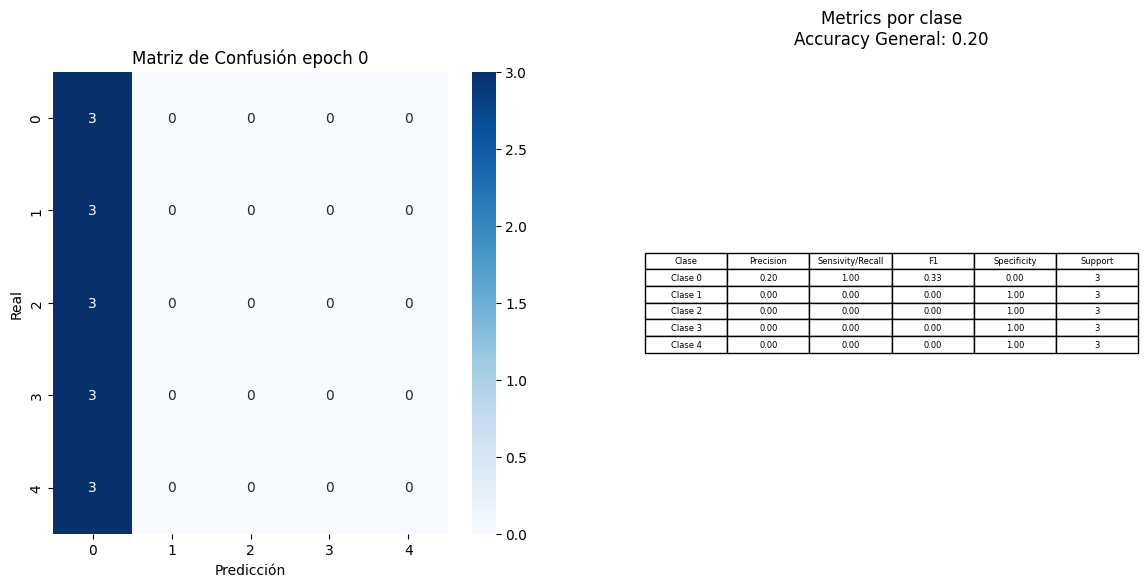

In [3]:

train_model(model, trainer, train_dataset, val_dataset, epochs=2, device=device, wdb=False)



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
BATCH_SIZE = 5
LEARNING_RATE = 0.01
FACTOR = 0.001
L1 = 0.00
L2 = 0.00
PATIENCE = 5
BETAS=(0.9, 0.999)
# Regularización L1 y L2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = OriginalOAIDataset('train', batch_size=BATCH_SIZE, transform=transform, local=True, path=MENDELEY_EXPERT1_SPLIT_PATH)
val_dataset = OriginalOAIDataset('val', batch_size=BATCH_SIZE, transform=transform, local=True, path=MENDELEY_EXPERT1_SPLIT_PATH)
model = EfficientNetB5Custom(num_classes = 5, pretrained=False)
model = EfficientNetB4(num_classes=5, pretrained=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Classification(model, device, L1=L1, L2=L2, lr=LEARNING_RATE, factor=FACTOR, patience=PATIENCE, betas=BETAS)